In [1]:
import cartopy.feature as feature
import cartopy.crs as ccrs
from calendar import month_abbr
import matplotlib.dates as mdates
from pathlib import Path 
import subprocess 
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import datetime
import numpy as np
import pandas as pd
import xarray
import xesmf
import os 
from glob import glob
from plot_common import autoextend_colorbar, corners, get_map_norm, open_var, add_ticks, annotate_skill, save_figure
from scipy.stats import ttest_1samp
import statistics
import scipy 

In [2]:
def open_var(pp_root, kind, var):
    freq = 'daily' if 'daily' in kind else 'monthly'
    longslice = '19930101-19981231' if freq == 'daily' else '199301-199812'
    longfile = os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.{longslice}.{var}.nc')
    if os.path.isfile(longfile):
        os.system(f'dmget {longfile}')
        return xarray.open_dataset(longfile)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    else:
        raise Exception('Did not find postprocessed files')

In [3]:
import xgcm
static = (
    xarray.open_dataset('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod/pp/ocean_monthly/ocean_monthly.static.nc')
    .squeeze()
    .drop_vars('time', errors = 'ignore')
)
xgrid = xgcm.Grid(
    static,
    coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
    },
    metrics={
        ('X', ): ['dxt'],
        ('Y', ): ['dyt'], 
        ('X', 'Y'): ['areacello']
    },
    periodic=[],
    boundary='fill'
)

In [4]:
rootmed1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootmed2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod') 
rootmed3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod') 
rootmed4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod') 
rootmed5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod') 

rootlow1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootlow2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_2/gfdl.ncrc5-intel22-prod')
rootlow3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_3/gfdl.ncrc5-intel22-prod')
rootlow4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_4/gfdl.ncrc5-intel22-prod')
rootlow5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_5/gfdl.ncrc5-intel22-prod')

In [5]:
rooteras = Path('/archive/acr/fre/NWA/2024_04_update/NWA12_COBALT_2024_04_nudgets-90d/gfdl.ncrc5-intel22-prod')

In [6]:
tauuomed1 = open_var(rootmed1, 'ocean_monthly', 'tauuo') 
tauuomed2 = open_var(rootmed2, 'ocean_monthly', 'tauuo') 
tauuomed3 = open_var(rootmed3, 'ocean_monthly', 'tauuo') 
tauuomed4 = open_var(rootmed4, 'ocean_monthly', 'tauuo') 
tauuomed5 = open_var(rootmed5, 'ocean_monthly', 'tauuo') 

tauuolow1 = open_var(rootlow1, 'ocean_monthly', 'tauuo') 
tauuolow2 = open_var(rootlow2, 'ocean_monthly', 'tauuo') 
tauuolow3 = open_var(rootlow3, 'ocean_monthly', 'tauuo') 
tauuolow4 = open_var(rootlow4, 'ocean_monthly', 'tauuo') 
tauuolow5 = open_var(rootlow5, 'ocean_monthly', 'tauuo') 

tauvomed1 = open_var(rootmed1, 'ocean_monthly', 'tauvo') 
tauvomed2 = open_var(rootmed2, 'ocean_monthly', 'tauvo') 
tauvomed3 = open_var(rootmed3, 'ocean_monthly', 'tauvo') 
tauvomed4 = open_var(rootmed4, 'ocean_monthly', 'tauvo') 
tauvomed5 = open_var(rootmed5, 'ocean_monthly', 'tauvo') 

tauvolow1 = open_var(rootlow1, 'ocean_monthly', 'tauvo') 
tauvolow2 = open_var(rootlow2, 'ocean_monthly', 'tauvo') 
tauvolow3 = open_var(rootlow3, 'ocean_monthly', 'tauvo') 
tauvolow4 = open_var(rootlow4, 'ocean_monthly', 'tauvo') 
tauvolow5 = open_var(rootlow5, 'ocean_monthly', 'tauvo') 

In [12]:
wsmagmed1 = np.hypot(xgrid.interp(tauuomed1gom, 'X'), xgrid.interp(tauvomed1gom, 'Y'))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [13]:
wsmagmed2 = np.hypot(xgrid.interp(tauuomed2gom, 'X'), xgrid.interp(tauvomed2gom, 'Y'))

In [14]:
wsmagmed3 = np.hypot(xgrid.interp(tauuomed3gom, 'X'), xgrid.interp(tauvomed3gom, 'Y'))

In [15]:
wsmagmed4 = np.hypot(xgrid.interp(tauuomed4gom, 'X'), xgrid.interp(tauvomed4gom, 'Y'))

In [16]:
wsmagmed5 = np.hypot(xgrid.interp(tauuomed5gom, 'X'), xgrid.interp(tauvomed5gom, 'Y'))

In [17]:
wsmaglow1 = np.hypot(xgrid.interp(tauuolow1gom, 'X'), xgrid.interp(tauvolow1gom, 'Y'))

In [18]:
wsmaglow2 = np.hypot(xgrid.interp(tauuolow2gom, 'X'), xgrid.interp(tauvolow2gom, 'Y'))

In [19]:
wsmaglow3 = np.hypot(xgrid.interp(tauuolow3gom, 'X'), xgrid.interp(tauvolow3gom, 'Y'))

In [20]:
wsmaglow4 = np.hypot(xgrid.interp(tauuolow4gom, 'X'), xgrid.interp(tauvolow4gom, 'Y'))

In [21]:
wsmaglow5 = np.hypot(xgrid.interp(tauuolow5gom, 'X'), xgrid.interp(tauvolow5gom, 'Y'))

In [22]:
wsmaghist = np.hypot(xgrid.interp(tauuohistgom, 'X'), xgrid.interp(tauvohistgom, 'Y'))

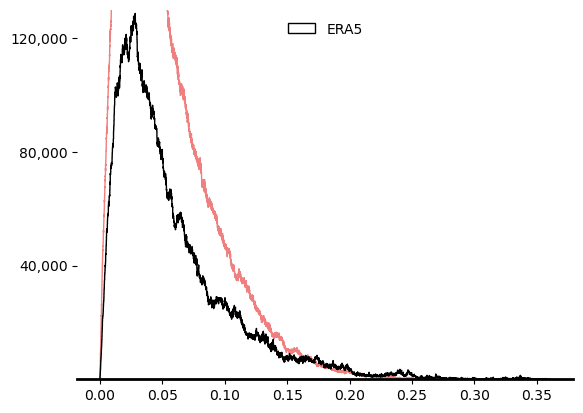

In [25]:
plt.hist(lowdata, bins=10000, color='lightcoral', histtype ='step') 
#plt.hist(meddata**.25, bins=10000, color='lightblue', histtype ='step')
plt.hist(wsmaghist.values.flatten(), bins=4000, color='black', histtype='step', label='ERA5') 
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none') 
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_linewidth(2) 
plt.ylim(0,130000) 
plt.yticks([40000,80000,120000], ["40,000","80,000","120,000"]) 
plt.legend(loc = 'upper center', frameon=False, ncol=2)
plt.rcParams['figure.dpi'] = 1600

In [26]:
plt.hist(lowdata, bins=40000, color='lightcoral', histtype ='step') 
plt.hist(meddata, bins=40000, color='lightblue', histtype ='step')
plt.hist(wsmaghist.values.flatten(), bins=4000, color='black', histtype='step', label='ERA5') 
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none') 
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_linewidth(2) 
plt.ylim(0,130000) 
plt.yticks([40000,80000,120000], ["40,000","80,000","120,000"]) 
plt.legend(loc = 'upper center', frameon=False, ncol=2)
plt.rcParams['figure.dpi'] = 1600

In [34]:
plt.hist(lowdata, bins=10000, color='lightcoral', histtype ='step', label='Low Resolution', density = True) 
plt.hist(meddata, bins=10000, color='lightblue', histtype ='step', label='Medium Resolution', density = True)
plt.hist(wsmaghist.values.flatten(), bins=4000, color='black', histtype='step', label='ERA5', density = True) 
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none') 
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_linewidth(2) 
plt.legend(loc = 'upper right', frameon=False, ncol=2)
plt.rcParams['figure.dpi'] = 1600

In [ ]:
# Calculate the 50th and 99th percentiles
percentiles_med = np.nanpercentile(meddata, [50, 99])
percentiles_low = np.nanpercentile(lowdata, [50, 99])
percentiles_eras = np.nanpercentile(wsmaghist.values.flatten(), [50,99]) 

# Prepare the data for barplot
labels = ['50th Percentile', '99th Percentile']
med_values = percentiles_med
low_values = percentiles_low
eras_values = percentiles_eras 

x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar((1.5 * x), med_values, width, label='datamed',color='lightblue')
bar2 = ax.bar((1.5 * x) + width, low_values, width, label='datalow',color='lightcoral')
bar3 = ax.bar((1.5 * x) - width, eras_values, width, color='black')  

ax.set_xticks(1.5 * x)
ax.set_xticklabels(labels)

ax.set_yticks([])
ax.set_yticklabels([])

plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none') 
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_linewidth(2)
plt.yticks()

# Add value labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)
add_value_labels(bar3) 

plt.rcParams['figure.dpi'] = 1600

# Show the plot
plt.show()

In [7]:
masks = xarray.open_dataset('/home/Andrew.C.Ross/git/nwa12/data/geography/masks/regions_30m.nc')

In [8]:
weights = masks['areacello'].where(masks['GOM']).fillna(0)

In [9]:
tauuomed1gom = tauuomed1.weighted(weights).mean(['yh', 'xh']).compute()
tauuomed2gom = tauuomed2.weighted(weights).mean(['yh', 'xh']).compute()
tauuomed3gom = tauuomed3.weighted(weights).mean(['yh', 'xh']).compute()
tauuomed4gom = tauuomed4.weighted(weights).mean(['yh', 'xh']).compute()
tauuomed5gom = tauuomed5.weighted(weights).mean(['yh', 'xh']).compute()

tauuolow1gom = tauuolow1.weighted(weights).mean(['yh', 'xh']).compute()
tauuolow2gom = tauuolow2.weighted(weights).mean(['yh', 'xh']).compute()
tauuolow3gom = tauuolow3.weighted(weights).mean(['yh', 'xh']).compute()
tauuolow4gom = tauuolow4.weighted(weights).mean(['yh', 'xh']).compute()
tauuolow5gom = tauuolow5.weighted(weights).mean(['yh', 'xh']).compute()

In [10]:
tauuohistgom = open_var(rooteras, 'ocean_monthly', 'tauuo').weighted(weights).mean(['yh', 'xh']).compute()
tauvohistgom = open_var(rooteras, 'ocean_monthly', 'tauvo').weighted(weights).mean(['yh', 'xh']).compute()

In [11]:
tauvomed1gom = tauvomed1.weighted(weights).mean(['yh', 'xh']).compute()
tauvomed2gom = tauvomed2.weighted(weights).mean(['yh', 'xh']).compute()
tauvomed3gom = tauvomed3.weighted(weights).mean(['yh', 'xh']).compute()
tauvomed4gom = tauvomed4.weighted(weights).mean(['yh', 'xh']).compute()
tauvomed5gom = tauvomed5.weighted(weights).mean(['yh', 'xh']).compute()

tauvolow1gom = tauvolow1.weighted(weights).mean(['yh', 'xh']).compute()
tauvolow2gom = tauvolow2.weighted(weights).mean(['yh', 'xh']).compute()
tauvolow3gom = tauvolow3.weighted(weights).mean(['yh', 'xh']).compute()
tauvolow4gom = tauvolow4.weighted(weights).mean(['yh', 'xh']).compute()
tauvolow5gom = tauvolow5.weighted(weights).mean(['yh', 'xh']).compute()

In [23]:
meddata = np.concatenate([wsmagmed1.values.flatten(), wsmagmed2.values.flatten(), wsmagmed3.values.flatten(), wsmagmed4.values.flatten(), wsmagmed5.values.flatten()])

In [24]:
lowdata = np.concatenate([wsmaglow1.values.flatten(), wsmaglow2.values.flatten(), wsmaglow3.values.flatten(), wsmaglow4.values.flatten(), wsmaglow5.values.flatten()])